In [1]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'

data_dir = '/Users/iaincarmichael/Documents/courtlistener/data/'

import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from collections import Counter

# graph package
import igraph as ig

# our code
sys.path.append(repo_directory + 'code/')
from setup_data_dir import setup_data_dir, make_subnetwork_directory
from pipeline.download_data import download_bulk_resource, download_master_edgelist, download_scdb
from helpful_functions import case_info

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')
from rankscore_experiment_sort import *
from rankscore_experiment_LR import *
from rankscore_experiment_search import *

from make_tr_edge_df import *

# which network to download data for
network_name = 'scotus' # 'federal', 'ca1', etc


# some sub directories that get used
raw_dir = data_dir + 'raw/'
subnet_dir = data_dir + network_name + '/'
text_dir = subnet_dir + 'textfiles/'


# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load scotes
G = ig.Graph.Read_GraphML(subnet_dir + network_name +'_network.graphml')

In [3]:
# get a small sugraph to work wit
np.random.seed(234)
v = G.vs[np.random.choice(range(len(G.vs)))]

subset_ids = G.neighborhood(v.index, order=2)
g = G.subgraph(subset_ids)

In [4]:
# get adjacency matrix
A = np.array(g.get_adjacency().data)

# helper functions

In [3]:
def get_leading_evector(M, normalized=True):
    evals, evecs = np.linalg.eig(M)

    # there really has to be a more elegant way to do this
    return np.real(evecs[:, np.argmax(evals)].reshape(-1))

# parameters

In [6]:
n = len(g.vs)

case_years = np.array(g.vs['year']).astype(int)
Y = case_years - min(case_years) # zero index the years

m = max(Y) + 1

In [7]:
cases_per_year = [0] * m
cases_per_year_counter = Counter(Y)

for k in cases_per_year_counter.keys():
    cases_per_year[k] = cases_per_year_counter[k]

In [8]:
p = .85
qtv = .8
qvt = .2

# PageRank transition matrix

In [9]:
# set up the page rank transition matrix

D = np.diag([0 if d == 0 else 1.0/d for d in g.outdegree()])

z = [1.0/n if d == 0 else (1.0 - p) / n for d in g.outdegree()]

PR = p * np.dot(A.T, D) + np.outer([1] * n, z)

In [10]:
np.allclose(PR.sum(axis=0), [1]*n)

True

In [11]:
pr = get_leading_evector(PR)
pr = pr/sum(pr) # scale to probability

In [12]:
# check again igraph's page rank value
# TODO: still a little off
pr_ig = np.array(g.pagerank(damping = p))
print "sum square diff: %f " % sum(np.square(pr_ig - pr))
print "mean: %f" % np.mean(pr)

sum square diff: 0.000000 
mean: 0.004292


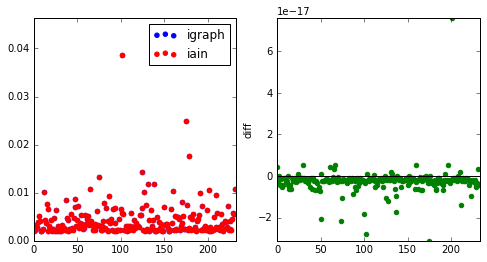

In [17]:
plt.figure(figsize=[8, 4])
plt.subplot(1,2,1)
plt.scatter(range(n), pr_ig, color='blue', label='igraph')
plt.scatter(range(n), pr, color='red', label='iain')
plt.xlim([0, n])
plt.ylim([0, 1.2 * max(max(pr_ig), max(pr))])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
diff = pr_ig - pr
plt.scatter(range(n), diff, color='green')
plt.ylabel('diff')
plt.xlim([0, n])
plt.ylim(min(diff), max(diff))
plt.axhline(0, color='black')


# time-time transition matrix

ones on line below diagonal

In [18]:
TT = np.zeros((m, m))
TT[1:m, :m-1] = np.diag([1] * (m - 1))

# vertex - time transition matrix

the i-th column is the Y[i]th basis vector

In [19]:
VT = np.zeros((m, n))

# for basis vectors
identity_m = np.eye(m)

for i in range(n):
    VT[:, i] = identity_m[:, Y[i]]

In [20]:
np.allclose(VT.sum(axis=0), [1]*n)

True

# time - vertex transition matrix

VT transpose but entries are scaled by number of cases in the year

In [21]:
TV = np.zeros((n, m))

n_inv = [0 if cases_per_year[i] == 0 else 1.0/cases_per_year[i] for i in range(m)]

for i in range(n):
    TV[i, :] = identity_m[Y[i], :] * n_inv[Y[i]]

In [22]:
qtv_diag = [0 if cases_per_year[i] == 0 else qtv for i in range(m)]
qtv_diag[-1] = 1
Qtv = np.diag(qtv_diag)

# Make overall transition matrix

In [23]:
print sum(PR[:, 0])
print sum(VT[0, :])
print sum(TT[0, :])
print sum(TV[0, :])

1.0
1.0
0.0
0.25


In [24]:
P = np.zeros((n + m, n + m))

# upper left
P[:n, :n] = (1 - qvt) * PR

# upper right
P[:n, -m:] = np.dot(TV, Qtv)

# lower left
P[n:, :-m] = qvt * VT

# lower right
P[-m:, -m:] = np.dot(TT, np.eye(m) - Qtv)

In [25]:
np.allclose(P.sum(axis=0), [1]*(n + m))

True

In [26]:
ta_pr = get_leading_evector(P)
ta_pr = ta_pr/sum(ta_pr)

# time aware page rank function

In [4]:
def time_aware_pagerank(A, years, p, qtv, qvt):
    """
    Computes the time aware PageRank defined by the following random walk
    
    Create bi-partide graph time graph F whose vertices are the original vertices
    of G and the vertex years. 
    - F contains a copy of G
    - edge from each vetex to AND from its year
    - edges go from year to the following year
    
    When the random walk is at a vertex of G
    - probability qvt transitions to the time node
    - probability 1 - qvt does a PageRank move
    
    When the random walk is at a time node
    - probability qtv transitions to a vertex in G (of the corresponding year)
    - probability 1 - qtv moves to the next year
    
    Parameters
    ----------
    A: adjacency matrix of original matrix where Aij = 1 iff there is an edge from i to j
    
    Y: the years assigned to each node

    p: PageRank parameter
    
    qtv: probability of transitioning from time to vertex in original graph
    
    qvt: probability of transitioning from vertx to time 
    
    Output
    ------
    
    """
    # number of vertices in the graph
    n = A.shape[0]
    outdegrees = A.sum(axis=1)
    
    # zero index the years
    Y = np.array(years) - min(years) 

    # number of years in graph
    m = max(Y) + 1
    
    # PageRank transition matrix
    # (see murphy 17.37)
    D = np.diag([0 if d == 0 else 1.0/d for d in outdegrees])
    z = [1.0/n if d == 0 else (1.0 - p) / n for d in outdegrees]
    PR = p * np.dot(A.T, D) + np.outer([1] * n, z)
    
    # Time-Time transition matrix
    # ones below diagonal
    TT = np.zeros((m, m))
    TT[1:m, :m-1] = np.diag([1] * (m - 1))
    
    
    # Vertex-Time transition matrix
    # i-th column is the Y[i]th basis vector
    VT = np.zeros((m, n))
    identity_m = np.eye(m) # for basis vectors
    for i in range(n):
        VT[:, i] = identity_m[:, Y[i]]
        
    
    # Time-Vertex transition matrix
    # VT transpose but entries are scaled by number of cases in the year
    TV = np.zeros((n, m))
    # 1 over number of cases per year
    n_inv = [0 if cases_per_year[i] == 0 else 1.0/cases_per_year[i] for i in range(m)]
    for i in range(n):
        TV[i, :] = identity_m[Y[i], :] * n_inv[Y[i]]

    
    # normalization matrix for TV
    qtv_diag = [0 if cases_per_year[i] == 0 else qtv for i in range(m)]
    qtv_diag[-1] = 1 # last column of TT is zeros
    Qtv = np.diag(qtv_diag)
        
        
    # overall transition matrix
    P = np.zeros((n + m, n + m))

    # upper left
    P[:n, :n] = (1 - qvt) * PR

    # upper right
    P[:n, -m:] = np.dot(TV, Qtv)

    # lower left
    P[n:, :-m] = qvt * VT

    # lower right
    P[-m:, -m:] = np.dot(TT, np.eye(m) - Qtv)
    
    # get PageRank values
    leading_eig = get_leading_evector(P)
    ta_pr = leading_eig[:n]
    pr_years = leading_eig[-m:]
    
    return ta_pr/sum(ta_pr), pr_years/sum(pr_years)

# test

In [5]:
p = .85
qtv = .8
qvt = .2

In [ ]:
%%time
A = np.array(G.get_adjacency().data)
years = np.array(G.vs['year']).astype(int)

In [7]:
%%time
ta_pr, pr_years =  time_aware_pagerank(A, years, p, qtv, qvt)

NameError: global name 'cases_per_year' is not defined

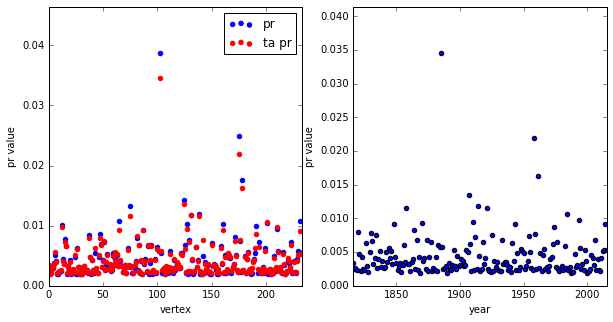

In [50]:
plt.figure(figsize=[10, 5])

# plot pr and ta_pr
plt.subplot(1,2,1)
plt.scatter(range(n), pr, color='blue', label='pr')
plt.scatter(range(n), ta_pr[:n], color='red', label='ta pr')
plt.xlim([0, n])
plt.ylim([0, 1.2 * max(max(ta_pr), max(pr))])
plt.legend(loc='upper right')
plt.xlabel('vertex')
plt.ylabel('pr value')

# plot time
plt.subplot(1,2,2)
plt.scatter(range(min(years), max(years) + 1), ta_pr[-m:])
plt.xlim([min(years), max(years) ])
plt.ylim([0, 1.2 * max(ta_pr[-m:])])
plt.ylabel('pr value')
plt.xlabel('year')